## create parquet file (Creating the virtual store)

In [1]:
from virtualizarr import open_virtual_dataset
import glob
import xarray as xr
import fsspec
import numpy as np
import pandas as pd

In [2]:
path = '/work/bm1344/k202193/ICON/erc2002/postprocessing/interpolation/oce_2d_1d_mean_remap025/'

virtual_datasets = [
    open_virtual_dataset(filepath)
    for filepath in sorted(glob.glob(path +'run*/erc2002_*.nc'))
]

stored_attrs = {}
coord_attrs = {}

# Store attributes
for dataset in virtual_datasets:
    for var_name in dataset.data_vars:
        if var_name not in stored_attrs:
            stored_attrs[var_name] = dataset[var_name].attrs

    for coord_name in dataset.coords:
        if coord_name not in coord_attrs:
            coord_attrs[coord_name] = dataset.coords[coord_name].attrs

# Combine datasets along the time dimension 
virtual_ds = xr.combine_nested(virtual_datasets, concat_dim=['time'], 
                               coords='minimal', 
                               compat='override', 
                               fill_value=-8.e+33)

# Fix time coordinate manually if it's incorrect
if 'time' in virtual_ds.coords:
    time_units = "minutes since 1950-01-01 00:00:00"
    calendar = "gregorian"

    # Convert the time from float64 to datetime64 using correct units and origin
    new_time_values = pd.to_datetime(virtual_ds['time'].values, unit='m', origin=pd.Timestamp('1950-01-01 00:00:00'))

    # Use assign_coords to update the time coordinate
    virtual_ds = virtual_ds.assign_coords(time=new_time_values)

    # Set the correct attributes for the time coordinate
    virtual_ds['time'].attrs.update({
        'units': time_units,
        'calendar': calendar,
        'standard_name': 'time'
    })

# Reassign attributes to data variables and coordinates
for var_name, attrs in stored_attrs.items():
    if var_name in virtual_ds.data_vars:
        virtual_ds[var_name].attrs = attrs

for coord_name, attrs in coord_attrs.items():
    if coord_name in virtual_ds.coords:
        virtual_ds.coords[coord_name].attrs = attrs

virtual_ds = virtual_ds.drop_vars('height_2_bnds', errors='ignore')

virtual_ds.virtualize.to_kerchunk('oce_2d_1d_mean_remap025.parq', format='parquet')

/work/bm1344/conda-envs/virtualizarr/lib/python3.12/site-packages/virtualizarr/xarray.py:160: UserWarning: Specifying `indexes=None` will create in-memory pandas indexes for each 1D coordinate, but concatenation of ManifestArrays backed by pandas indexes is not yet supported (see issue #18).You almost certainly want to pass `indexes={}` to `open_virtual_dataset` instead.
  warnings.warn(


In [3]:
virtual_ds

<xarray.Dataset> Size: 567GB
Dimensions:                              (time: 4019, depth: 1, lat: 721,
                                          lon: 1440, lev: 1)
Coordinates:
  * lat                                  (lat) float64 6kB -90.0 -89.75 ... 90.0
  * lon                                  (lon) float64 12kB 0.0 0.25 ... 359.8
  * lev                                  (lev) float64 8B 0.0
  * depth                                (depth) float64 8B 1.0
  * time                                 (time) datetime64[ns] 32kB 1980-01-0...
Data variables: (12/34)
    to                                   (time, depth, lat, lon) float32 17GB ManifestArray<shape=(4019, 1, 721, 1440), dtype=float32, chunks=(1, 1, 721, 1440)...
    newice                               (time, lat, lon) float32 17GB Manife...
    hi                                   (time, lev, lat, lon) float32 17GB M...
    u                                    (time, depth, lat, lon) float32 17GB ManifestArray<shape=(4019, 1, 721, 1440), dtype=float32, chunks=(1, 1, 721, 1440)...
    sea_level_pressure                   (time, lat, lon) float32 17GB Manife...
    atmos_fluxes_FrshFlux_Evaporation    (time, lat, lon) float32 17GB Manife...
    ...                                   ...
    FrshFlux_IceSalt                     (time, lat, lon) float32 17GB Manife...
    atmos_fluxes_stress_x                (time, lat, lon) float32 17GB Manife...
    atmos_fluxes_FrshFlux_SnowFall       (time, lat, lon) float32 17GB Manife...
    atmos_fluxes_HeatFlux_LongWave       (time, lat, lon) float32 17GB Manife...
    mlotst10                             (time, lat, lon) float32 17GB Manife...
    atmos_fluxes_HeatFlux_Sensible       (time, lat, lon) float32 17GB Manife...
Attributes:
    coordinates:  lat lon lev depth time

### open new Zarr store 

In [7]:
#fs = fsspec.filesystem('reference', fo='modified_combined_o.json')
#m = fs.get_mapper('')

ds = xr.open_dataset('/work/bm1344/k202193/Kerchunk/oce_2d_1d_mean_remap025.parq', engine="kerchunk")

In [8]:
ds

<xarray.Dataset> Size: 567GB
Dimensions:                              (time: 4019, lat: 721, lon: 1440,
                                          lev: 1, depth: 1)
Coordinates:
  * depth                                (depth) float64 8B 1.0
  * lat                                  (lat) float64 6kB -90.0 -89.75 ... 90.0
  * lev                                  (lev) float64 8B 0.0
  * lon                                  (lon) float64 12kB 0.0 0.25 ... 359.8
  * time                                 (time) datetime64[ns] 32kB 1980-01-0...
Data variables: (12/34)
    FrshFlux_IceSalt                     (time, lat, lon) float32 17GB ...
    FrshFlux_TotalIce                    (time, lat, lon) float32 17GB ...
    Wind_Speed_10m                       (time, lat, lon) float32 17GB ...
    atmos_fluxes_FrshFlux_Evaporation    (time, lat, lon) float32 17GB ...
    atmos_fluxes_FrshFlux_Precipitation  (time, lat, lon) float32 17GB ...
    atmos_fluxes_FrshFlux_Runoff         (time, lat, lon) float32 17GB ...
    ...                                   ...
    so                                   (time, depth, lat, lon) float32 17GB ...
    ssh                                  (time, lat, lon) float32 17GB ...
    stretch_c                            (time, lat, lon) float32 17GB ...
    to                                   (time, depth, lat, lon) float32 17GB ...
    u                                    (time, depth, lat, lon) float32 17GB ...
    v                                    (time, depth, lat, lon) float32 17GB ...

In [10]:
so = ds.to[:,0,:,:]
so

<xarray.DataArray 'to' (time: 3790, lat: 721, lon: 1440)> Size: 16GB
[3934929600 values with dtype=float32]
Coordinates:
    depth    float64 8B 1.0
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 30kB 1980-01-01 1980-01-02 ... 1991-01-01
Attributes:
    long_name:      sea water potential temperature
    param:          18.4.10
    standard_name:  sea_water_potential_temperature
    units:          C

In [8]:
so.max().values

array(32.968674, dtype=float32)

In [9]:
so.min().values

array(-1.8002557, dtype=float32)

In [8]:
lon = so["lon"]
lat = so["lat"]

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

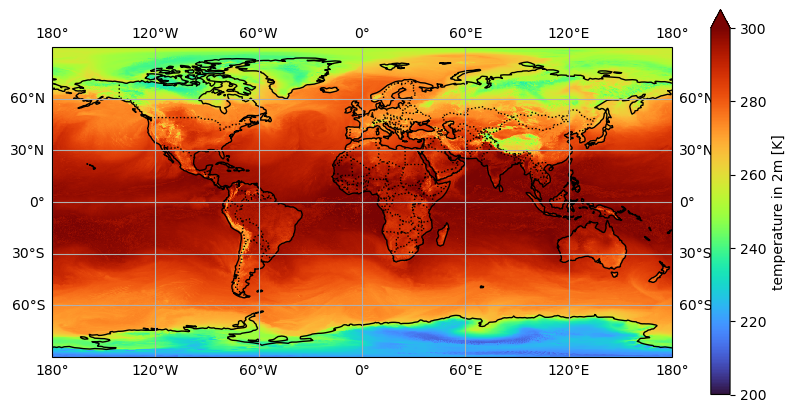

In [10]:
vmin = 200
vmax = 300

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

so.plot(ax=ax, transform=ccrs.PlateCarree(), 
           cmap='turbo', 
                 vmin=vmin, 
                 vmax=vmax, 
          )

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

plt.title('')
plt.show()

### miscellaneous

In [9]:
# Find missing days

import numpy as np
import pandas as pd

start_date = '1980-01-01'
end_date = '1990-12-31'
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

actual_dates = pd.to_datetime(ds.time.values)

missing_days = expected_dates.difference(actual_dates)

if not missing_days.empty:
    print("Missing days:")
    for missing_day in missing_days:
        print(missing_day)
else:
    print("No days are missing!")


No days are missing!


In [6]:
variables = list(ds.data_vars)
print("Variables:")
print(variables)

# Print the list of variable attributes (like long name, standard name, etc.)
long_names = []
for var in ds.data_vars:
    long_name = ds[var].attrs.get('long_name', 'N/A')
    #param = ds[var].attrs.get('param', 'N/A')
    #standard_name = ds[var].attrs.get('standard_name', 'N/A')
    #units = ds[var].attrs.get('units', 'N/A')
    
    long_names.append({
        #'Variable': var,
         long_name,
        #'param': param,
        #'standard_name': standard_name,
       # 'units': units
    })

print("\nVariable attributes:")
for attr in long_names:
    print(attr)


Variables:
['FrshFlux_IceSalt', 'FrshFlux_TotalIce', 'Wind_Speed_10m', 'atmos_fluxes_FrshFlux_Evaporation', 'atmos_fluxes_FrshFlux_Precipitation', 'atmos_fluxes_FrshFlux_Runoff', 'atmos_fluxes_FrshFlux_SnowFall', 'atmos_fluxes_HeatFlux_Latent', 'atmos_fluxes_HeatFlux_LongWave', 'atmos_fluxes_HeatFlux_Sensible', 'atmos_fluxes_HeatFlux_ShortWave', 'atmos_fluxes_HeatFlux_Total', 'atmos_fluxes_stress_x', 'atmos_fluxes_stress_xw', 'atmos_fluxes_stress_y', 'atmos_fluxes_stress_yw', 'conc', 'delhi', 'delhs', 'hi', 'hs', 'ice_u', 'ice_v', 'mlotst', 'mlotst10', 'newice', 'sea_level_pressure', 'snow_to_ice', 'so', 'ssh', 'stretch_c', 'to', 'u', 'v']

Variable attributes:
{'Salt volume flux due to sea ice change'}
{'Freshwater Flux due to Sea Ice Change'}
{'Wind Speed at 10m height'}
{'atmos_fluxes_FrshFlux_Evaporation'}
{'atmos_fluxes_FrshFlux_Precipitation'}
{'atmos_fluxes_FrshFlux_Runoff'}
{'atmos_fluxes_FrshFlux_SnowFall'}
{'atmos_fluxes_HeatFlux_Latent'}
{'atmos_fluxes_HeatFlux_LongWave'}
{'

In [11]:
# Find the indices where the value matches
indices = np.where(so == 9.96921e+36)

# Print the indices or time when the value is found
print("Indices with the value 9.96921e+36:", indices)

Indices with the value 9.96921e+36: (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
